In [93]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset,random_split
from ipywidgets import IntProgress
import scipy.io.wavfile
import librosa
from skimage.transform import resize
import scipy.misc
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

from sklearn.metrics import accuracy_score
import sounddevice as sd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [94]:
resnet = models.resnet34(pretrained=True)

In [95]:
class ModifiedResNet(nn.Module):
            def __init__(self):
                super(ModifiedResNet, self).__init__()
                self.features = nn.Sequential(
                    #remove last fully connected layer
                    *list(resnet.children())[:-1]
                )
                self.dense1 = nn.Linear(512,128)
                self.dense_number = nn.Linear(128,10)
                self.dense_gender = nn.Linear(128,1)
            def forward(self, x):
              # input shape = batch_size,n_channels,height,width
                x = self.features(x) # output shape = batch_size * 512 * 1 * 1
                x = x.view(-1,512)
                x = nn.ReLU()(self.dense1(x)) # ouput shape = batch_size * 128
                number_pred = nn.Softmax()(self.dense_number(x))
                gender_pred = nn.Sigmoid()(self.dense_gender(x))

                return [number_pred,gender_pred]

In [96]:
model = ModifiedResNet()
model = model.to(device)

In [97]:
model.load_state_dict(torch.load(".\\models\\best_model_gender_gender_number_recognition",map_location=device))

<All keys matched successfully>

Audio pre-processing

In [98]:
def pad_signal(signal, target_len):
    
    num_zeros_needed = target_len - len(signal)
    
    if num_zeros_needed > 0:

        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')

    else:
        return signal

In [352]:
freq = 48000
sample_rate = 48000
duration = 0.9999583333333333
max_samples=47998
kPRE_EMPHASIS_COEFF = 0.97
def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - kPRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

In [344]:
def pipeline(signal):
    
    emphasized_signal = pre_emphasis(signal)
    # the following code applies dft, mel filter banks, logging, dct and normalization all at once
    # truly convenient
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft = int(sample_rate * 0.025),
        hop_length= int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hanning',
        n_mels=40
    )

    return lifted_mfcc

In [345]:
def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).

    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.

    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.

    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.

    Examples
    --------
    >>> img = array([[ 91.06794177,   3.39058326,  84.4221549 ],
                     [ 73.88003259,  80.91433048,   4.88878881],
                     [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)

    """
    if data.dtype == np.uint8:
        return data

    if high < low:
        raise ValueError("`high` should be larger than `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data * 1.0 - cmin) * scale + 0.4999
    bytedata[bytedata > high] = high
    bytedata[bytedata < 0] = 0
    return np.cast[np.uint8](bytedata) + np.cast[np.uint8](low)

In [346]:
def preprocess_audio(audio):
    audio = pad_signal(audio, target_len=max_samples)
    mfc = pipeline(audio)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    mfc_3d=bytescale(mfc_3d,cmin=0,cmax=255)
    return mfc_3d

In [347]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 2272-19F5

 Directory of C:\Users\khalid\Desktop\QMUL\subjects\sem2\music\project\gender_recognition

11/04/2022  15:33    <DIR>          .
11/04/2022  15:33    <DIR>          ..
09/04/2022  22:33    <DIR>          .ipynb_checkpoints
09/04/2022  00:34            10,358 4_0_37_15.jpg
08/04/2022  18:01       998,783,179 gender_recognition_data.zip
09/04/2022  16:11       153,785,257 gender_recognition_preprocessed_data.zip
11/04/2022  02:36    <DIR>          models
11/04/2022  15:33            67,675 music_project_gender_recognition_model_testing.ipynb
10/04/2022  00:08           206,422 music_project_gender_recognition_preprocessing.ipynb
11/04/2022  11:43    <DIR>          results
11/04/2022  15:16    <DIR>          test
               5 File(s)  1,152,852,891 bytes
               6 Dir(s)  16,847,724,544 bytes free


The system cannot find the path specified.


In [365]:
sr, signal = scipy.io.wavfile.read(".\\test\\female\\9.wav")  # faster than librosa
len(signal)
print(signal.shape)
signal = signal[:,0]
print(signal.shape)
signal = pad_signal(signal, target_len=max_samples)
mfc = pipeline(signal)
mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
mfc_3d=bytescale(mfc_3d,cmin=0,cmax=255)
im = Image.fromarray(mfc_3d)
mfc_3d = torch.tensor(mfc_3d.reshape((3,224,224)),dtype = torch.float32)

with torch.no_grad():
    pred = model(mfc_3d[None,:])
if pred[1] >=0.5:
    gender = "Female"
else:
    gender = "Male"
print("number = " ,np.argmax(pred[0]).item())
print("gender is : ", gender)

(45056, 2)
(45056,)
number =  9
gender is :  Male


In [369]:
recording = sd.rec(int(duration * freq), 
               samplerate=freq, channels=1)

# Record audio for the given number of seconds
sd.wait()
print(recording.shape)
print(recording)
mfc_3d = preprocess_audio(recording[:,0])
im = Image.fromarray(mfc_3d.reshape((224,224,3)))
mfc_3d = mfc_3d.reshape(3,224,224)
mfc_3d = torch.tensor(mfc_3d[None,:],dtype=torch.float32)

with torch.no_grad():
    pred = model(mfc_3d)
    
print(torch.argmax(pred[0]))
print(pred[1])

(47998, 1)
[[ 0.0000000e+00]
 [ 0.0000000e+00]
 [-3.0517578e-05]
 ...
 [ 2.8533936e-02]
 [ 3.0212402e-02]
 [ 2.9846191e-02]]
tensor(0)
tensor([[0.0003]])


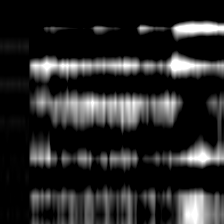

In [370]:
im

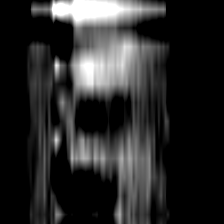

In [320]:
im

In [30]:
np.max(recording)

0.09158325

In [130]:
2**15

32768